# 検閲をなくせばM市場でも予測できるか

結論：できない

In [9]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv
from numpy.random import *
import numdifftools as nd
from sklearn import linear_model

In [10]:
a = st.uniform()
s = st.norm()
e = st.norm()
M = 30000
T = 3000
random = 101
beta1 = 0.8
beta2 = -0.5
beta3 = -0.5
delta = -0.25

## M市場

In [11]:
seed(1234)
df = pd.read_csv("non_censored_data.csv")
m = df.shape[0]
draw = randint(1,T+1,m) 
df["draw"] = draw
df["realized_entry"] = df.apply(lambda x: 0 if(x["draw"] <= x["num0"]) else 1 if(x["draw"] <= x["num1"]) else 2, axis = 1)

In [12]:
df["popdist1"] = df["Pop"] * df["Dist1"]
df["popdist2"]= df["Pop"] * df["Dist2"]
df["dist1dist2"]= df["Dist2"] * df["Dist1"]
df["pop_sq"] = df["Pop"]**2
df["dist1_sq"] = df["Dist1"]**2
df["dist2_sq"] = df["Dist2"]**2

df["pop_tr"] = df["Pop"]**3
df["dist1_tr"] = df["Dist1"]**3
df["dist2_tr"] = df["Dist2"]**3
df["pop_sqdist1"] = df["Pop"]**2 * df["Dist1"]
df["pop_sqdist2"] = df["Pop"]**2 * df["Dist2"]
df["dist1_sqpop"] = df["Pop"] * df["Dist1"]**2
df["dist1_sqdist2"] = df["Dist2"] * df["Dist1"]**2
df["dist2_sqpop"] = df["Pop"] * df["Dist2"]**2
df["dist2_sqdist1"] = df["Dist1"] * df["Dist2"]**2

In [13]:
# logit
logreg = linear_model.LogisticRegression(C=1e5, penalty='l1')
Y = df.realized_entry
X = df.drop(["Unnamed: 0", "diff", "num0", "num1", "num2", "draw", "realized_entry"],axis = 1)
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

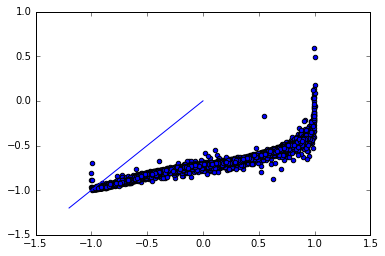

In [14]:
# diff estimation
# 検閲しないデータを用いるとdiffが正の値を取ることも十分あることに注意
# 検閲データと比して予測の精度が悪すぎる
df["diff_est"] = logreg.predict_proba(X)[:, 0] - logreg.predict_proba(X)[:, 2]
d = df["diff"].values
d_est = df["diff_est"].values
plt.scatter(d, d_est)
a = np.linspace(-1.2, 0,200)
plt.plot(a, a)
plt.show()

In [19]:
# 推定値を用いてRobust推定
def robust(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = (diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2))**2
    return -sum(r)

def robust1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2)
    return r

def NR(initial, fun, tol, maxit):
    theta = initial
    for i in range(0,maxit):
        G = nd.Gradient(fun)(theta)
        H = nd.Hessian(fun)(theta)
        del_theta = inv(H).dot(G)
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

In [21]:
pop = df[["Pop"]].values[:, 0]
dist1 = df[["Dist1"]].values[:, 0]
dist2 = df[["Dist2"]].values[:, 0]
num0 = df[["num0"]].values[:, 0]
num2 = df[["num2"]].values[:, 0]
tole = 0.005
maxx = 100
initial = [0.8,-0.5,-0.25]
diff = df[["diff_est"]].values[:, 0]
result_rob2 = NR(initial, robust, tole, maxx)

NR終わり


In [22]:
# 全然ダメ
result_rob2

array([ 5050.65273619, -8987.26946117,  1681.17605941])